In [1]:
import os
import shutil
import sys
import time
import warnings
from random import sample

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

import pytorch_lightning as L
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from torchmetrics.functional import mean_squared_error, mean_absolute_error

from pymatgen.core.composition import Composition

import torch
from torch.utils.data import DataLoader
from torch.nn import L1Loss, MSELoss, HuberLoss

data_type_np = np.float32
data_type_torch = torch.float32

import wandb

In [2]:
class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)
        
    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()if p.requires_grad)

In [4]:
from cgcnn.data import CIFData, collate_pool

## The data should be prepared as discribed in CIFdata doc-string

class CGCNNDataModule(L.LightningDataModule):
    def __init__(self, root_dir: str,
                 train_ratio: 0.8,
                 val_ratio: 0.1, 
                 test_ratio: 0.1,
                 collate_fn=collate_pool,
                 classification = False,
                 batch_size = 256,
                 num_workers=0,
                 pin_memory = True):
        super().__init__()
        self.dataset = CIFData(root_dir=root_dir, max_num_nbr=12, radius=10, dmin=0, step=0.2, random_seed=123)
        # root_dir, max_num_nbr=12, radius=8, dmin=0, step=0.2
        total_size = len(self.dataset)
        indices = list(range(total_size))
        
        self.collate_fn=collate_pool
        
        train_size = int(train_ratio * total_size)
        val_size = int(val_ratio * total_size)
        test_size = total_size - train_size - val_size
        self.train_sampler = SubsetRandomSampler(indices[:train_size])
        self.val_sampler = SubsetRandomSampler(indices[train_size:train_size+val_size])
        self.test_sampler = SubsetRandomSampler(indices[train_size+val_size:])
        
        self.batch_size = batch_size
        self.pin_memory = pin_memory
        self.classification = classification
        self.num_workers=num_workers
  
    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size,
                          sampler=self.train_sampler, num_workers=self.num_workers,
                          collate_fn=self.collate_fn, pin_memory=self.pin_memory)
    def val_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size,
                          sampler=self.val_sampler, num_workers=self.num_workers,
                          collate_fn=self.collate_fn, pin_memory=self.pin_memory,shuffle=False)
    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size,
                          sampler=self.test_sampler, num_workers=self.num_workers,
                          collate_fn=self.collate_fn, pin_memory=self.pin_memory,shuffle=False)
    def predict_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size,
                          sampler=self.test_sampler, num_workers=self.num_workers,
                          collate_fn=self.collate_fn, pin_memory=self.pin_memory,shuffle=False)

In [5]:
config={
    'root_dir': 'data/energy_data/',
    'train_ratio': 0.8,
    'val_ratio':0.1,
    'test_ratio':0.1,
    'atom_fea_len': 64,
    'n_conv': 3,
    'h_fea_len': 128,
    'n_h': 1,
    'classification': False,
    'batch_size': 256,
    'base_lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0,
    'dropout_fr': 0.1,
    'optim': 'AdamW',
    'pin_memory': True,
}

In [6]:
from cgcnn.model import CrystalGraphConvNet

class CGCNNLightning(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        
        self.dataset = CIFData(root_dir=config['root_dir'], max_num_nbr=12, radius=10, dmin=0, step=0.2, random_seed=123)
        structures, _, _ = self.dataset[0]
        orig_atom_fea_len = structures[0].shape[-1]
        nbr_fea_len = structures[1].shape[-1]
        
        self.model=CrystalGraphConvNet(orig_atom_fea_len=orig_atom_fea_len,
                                       nbr_fea_len=nbr_fea_len,
                                       atom_fea_len=config['atom_fea_len'], 
                                       n_conv=config['n_conv'], 
                                       h_fea_len=config['h_fea_len'], 
                                       n_h=config['n_h'],
                                       dropout_fr=config['dropout_fr'],
                                       classification=config['classification'])

        print(f'Model size: {count_parameters(self.model)} parameters\n')

        ### here we define some important parameters
        self.batch_size=config['batch_size']
        self.classification = config['classification']
        self.base_lr=config['base_lr']
        self.momentum=config['momentum']
        self.decay=config['weight_decay']
        
        ### normalizer
        if self.classification == True:
            self.normalizer = Normalizer(torch.zeros(2))
            self.normalizer.load_state_dict({'mean': 0., 'std': 1.})
        else:
            sample_data_list = [self.dataset[i] for i in sample(range(len(self.dataset)), 500)]
            _, sample_target, _ = collate_pool(sample_data_list)
            self.normalizer = Normalizer(sample_target)
        
        ### we also define loss function based on task
        if self.classification:
            print("Using BCE loss for classification task")
            self.criterion = BCEWithLogitsLoss
        else:
            # print("Using L1Loss loss for regression task")
            # self.criterion = L1Loss()
            # print('Using MSELoss loss for regression task')
            # self.criterion = MSELoss()
            print('Using HuberLoss for regression task')
            self.criterion = HuberLoss()

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        out=self.model(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)
        return out

    def configure_optimizers(self):
#         optimizer = optim.SGD(model.parameters(), self.base_lr,
#                               momentum=self.momentum,
#                               weight_decay=self.decay)
        optimizer = optim.AdamW(model.parameters(), self.base_lr,
                              weight_decay=self.decay)
        # lr_scheduler=StepLR(optimizer,
        #                     step_size=1,
        #                     gamma=0.5)
        
        # return [optimizer], [lr_scheduler]
        return [optimizer]

    def training_step(self, batch, batch_idx):
        graph, target, _ = batch
        if not self.classification:
            target_normed = self.normalizer.norm(target)
        else:
            target_normed = target.view(-1).long()
        
        input_var=(graph[0],graph[1],graph[2],graph[3])
        
        output = self(*input_var)
        loss = self.criterion(output, target_normed)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        
        if self.classification:
            pass
#             prediction = torch.sigmoid(prediction)
#             y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            
#             acc=balanced_accuracy_score(target_normed,y_pred)
#             f1=f1_score(target_normed,y_pred,average='weighted')
#             mc=matthews_corrcoef(target_normed,y_pred)
            
#             self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
#             self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
#             self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(target.cpu(),self.normalizer.denorm(output.data.cpu()))
            mae = mean_absolute_error(target.cpu(),self.normalizer.denorm(output.data.cpu()))
            self.log("train_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        graph, target, _ = batch
        if not self.classification:
            target_normed = self.normalizer.norm(target)
        else:
            target_normed = target.view(-1).long()
        
        input_var=(graph[0],graph[1],graph[2],graph[3])
        
        output = self(*input_var)
        loss = self.criterion(output, target_normed)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        
        if self.classification:
            pass
#             prediction = torch.sigmoid(prediction)
#             y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            
#             acc=balanced_accuracy_score(target_normed,y_pred)
#             f1=f1_score(target_normed,y_pred,average='weighted')
#             mc=matthews_corrcoef(target_normed,y_pred)
            
#             self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
#             self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
#             self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(target.cpu(),self.normalizer.denorm(output.data.cpu()))
            mae = mean_absolute_error(target.cpu(),self.normalizer.denorm(output.data.cpu()))
            self.log("val_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss
     
    def test_step(self, batch, batch_idx):
        graph, target, _ = batch
        if not self.classification:
            target_normed = self.normalizer.norm(target)
        else:
            target_normed = target.view(-1).long()
        
        input_var=(graph[0],graph[1],graph[2],graph[3])
        
        output = self(*input_var)
        
        if self.classification:
            pass
        else:
            mse = mean_squared_error(target,self.normalizer.denorm(output.data.cpu()))
            mae = mean_absolute_error(target,self.normalizer.denorm(output.data.cpu()))
            self.log("test_mse", float(mse), on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mae", float(mae), on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        graph, target, idx = batch
        if not self.classification:
            target_normed = self.normalizer.norm(target)
        else:
            target_normed = target.view(-1).long()
        
        input_var=(graph[0],graph[1],graph[2],graph[3])
        
        output = self(*input_var)
        if self.classification:
            pass
            return 
        else:
            graph, target, _ = batch
        if self.classification:
            target_normed = self.normalizer.norm(target)
        else:
            target_normed = target.view(-1).long()
        
        input_var=(graph[0],graph[1],graph[2],graph[3])
        output = self(*input_var)
        
        if self.classification:
            pass
            return
        else:
            return self.normalizer.denorm(output.data.cpu()), target, idx


In [7]:
config={
    'root_dir': 'data/cgcnn_data/',
    'train_ratio': 0.8,
    'val_ratio':0.1,
    'test_ratio':0.1,
    'atom_fea_len': 64,
    'n_conv': 3,
    'h_fea_len': 128,
    'n_h': 1,
    'classification': False,
    'batch_size': 128,
    'base_lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0,
    'optim': 'AdamW',
    'pin_memory': True,
    'patience': 100,
    'dropout_fr':0.1,
}

In [8]:
data=CGCNNDataModule(root_dir='data/cgcnn_data/', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

In [9]:
model = CGCNNLightning(**config)

Model size: 84673 parameters



/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


Using HuberLoss for regression task


In [10]:
trainer = Trainer(max_epochs=1000,accelerator='gpu', devices=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=config['patience']), 
                             ModelCheckpoint(monitor='val_mae', mode="min", 
                                dirpath='cgcnn_models/cgcnn_trained_models/', filename='eform-{epoch:02d}-{val_acc:.2f}')])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [11]:
trainer.fit(model, datamodule=data)

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339    

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 66613 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 25706 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 48801 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/c

Validation: |                                             | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 36736 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 26288 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 36803 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 15295 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 15368 not find enough neighbo

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [12]:
n1,n2,n3 = trainer.predict(ckpt_path='best', datamodule=data)[0]

Restoring states from the checkpoint path at /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models/eform-epoch=31-val_acc=0.00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models/eform-epoch=31-val_acc=0.00.ckpt
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 63277 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 39539 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 26051 not find enough neighbo

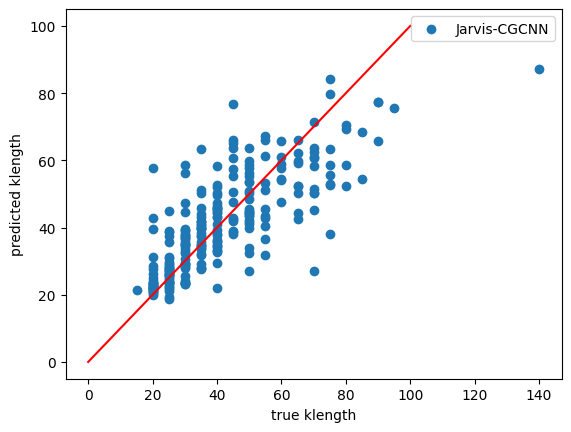

In [17]:
import matplotlib.pyplot as plt

plt.scatter(n2,n1,label='Jarvis-CGCNN')
plt.plot([0,100],[0,100],color='red')
plt.xlabel('true klength')
plt.ylabel('predicted klength')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

r2_score(n2,n1), mean_absolute_error(n2,n1)

(0.6157455690368215, 8.250450223684311)

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 

In [ ]:
trainer.fit(model, datamodule=data)

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/xyq44482/Documents/CGCNN/cgcnn_models/cgcnn_trained_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | CrystalGraphConvNet | 84.7 K | train
1 | criterion | HuberLoss           | 0      | train
----------------------------------------------------------
84.7 K    Trainable params
0         Non-trainable params
84.7 K    Total params
0.339     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 61265 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough neighbors to build graph. '
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/micromamba/envs/llm/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/xyq44482/Documents/CGCNN/cgcnn/data.py:333: UserWarning: 28778 not find enough neighbors to build graph. If it happens frequently, consider increase radius.
  warnings.warn('{} not find enough 